Identify AI-Exposed Jobs

This is a MUST, because your research question is:

“How is AI reshaping the Canadian job market?”

To measure AI exposure, we should define AI-sensitive occupations using:

keyword matching (e.g., "clerks", "analysts", "technicians", “transcription”, “support”)

external authoritative AI-risk lists (MIT, OECD, NBER AI Exposure Index)

We’re going to create an “AI_Risk_Level” column.

Loading Libraries Cell 1

In [2]:
# --- Core Libraries ---
import pandas as pd
import numpy as np

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 2000)

sns.set_style("whitegrid")


Loading Dataset Cell 2

Loaded wages_2020.csv → (43000, 16)
Loaded wages_2021.csv → (43000, 16)
Loaded wages_2022.csv → (43000, 17)
Loaded wages_2023.csv → (44376, 18)
Loaded wages_2024.csv → (44376, 21)
Combined dataset: (217752, 26)
After cleaning: (95099, 26)


/var/folders/3r/95cxm9wx64j9_7srtngmgn6h0000gn/T/ipykernel_11508/45556593.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


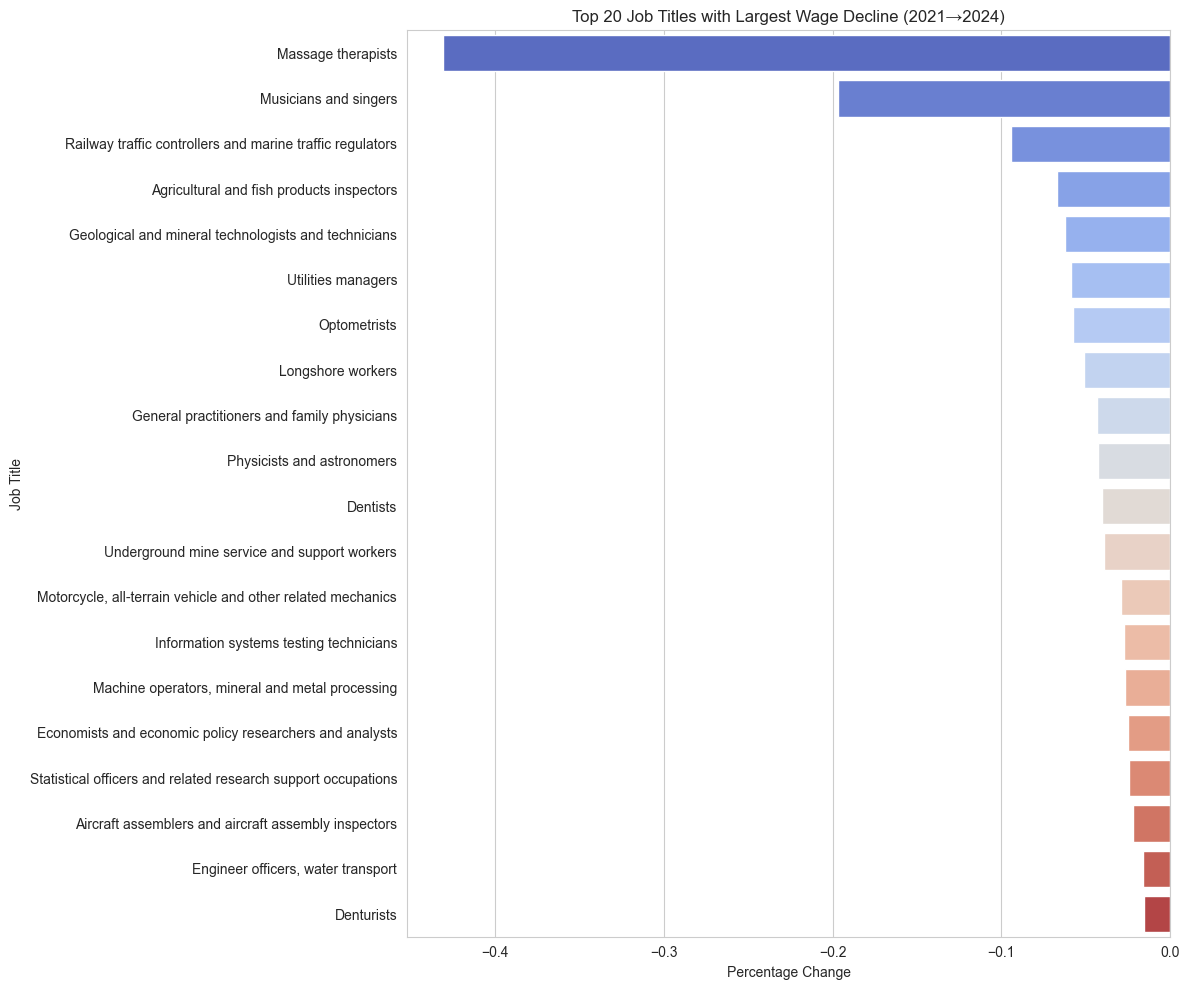

/var/folders/3r/95cxm9wx64j9_7srtngmgn6h0000gn/T/ipykernel_11508/45556593.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


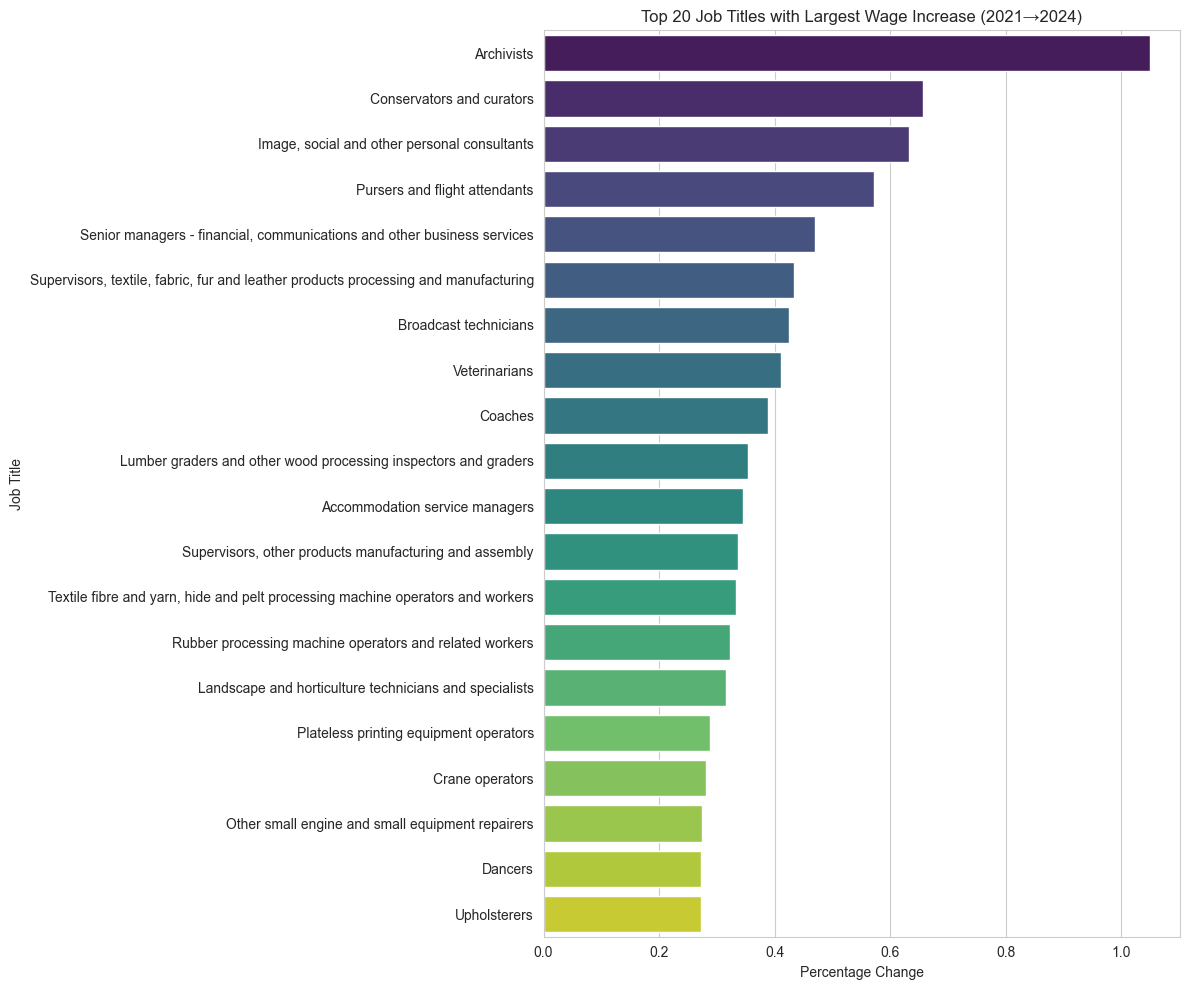

In [3]:
years = [2020, 2021, 2022, 2023, 2024]
wage_dfs = {}

for y in years:
    wage_dfs[y] = pd.read_csv(f"data/wages_{y}.csv", low_memory=False)
    print(f"Loaded wages_{y}.csv → {wage_dfs[y].shape}")

# --------------------------------------------
# NORMALIZATION FUNCTION — using ONLY provided job titles
# --------------------------------------------

def normalize(df, year):
    df = df.copy()
    df['year'] = year

    # Standardize job title columns across different years
    title_map = {
        'NOC_Title': 'job_title',
        'NOC_TITLE_ENG': 'job_title',
        'NOC_Title_eng': 'job_title'
    }
    df = df.rename(columns=title_map)

    # Standardize shared wage columns
    colmap = {
        'NOC_CNP': 'noc_code',
        'Median_Wage_Salaire_Median': 'median_wage',
        'Annual_Wage_Flag_Salaire_annuel': 'annual_wage_flag',
        'PROV': 'province',
        'prov': 'province'
    }
    df = df.rename(columns=colmap)

    # Ensure required columns exist (avoid KeyErrors)
    required = ['year','job_title','noc_code','median_wage','annual_wage_flag','province']
    for col in required:
        if col not in df.columns:
            df[col] = np.nan

    # Annualize if hourly (flag = 0)
    df['median_wage_annualized'] = np.where(
        df['annual_wage_flag'] == 0,
        df['median_wage'] * 2080,
        df['median_wage']
    )

    return df

normalized_dfs = [normalize(wage_dfs[y], y) for y in years]

all_years = pd.concat(normalized_dfs, ignore_index=True)

print("Combined dataset:", all_years.shape)
all_years.head()

clean = all_years.dropna(subset=['job_title', 'median_wage_annualized'])
clean = clean[clean['median_wage_annualized'] > 0]

print("After cleaning:", clean.shape)
clean.head()

trend = (
    clean.groupby(['job_title','year'])['median_wage_annualized']
    .median()
    .unstack()
)

trend['pct_change'] = (trend[2024] - trend[2021]) / trend[2021]

trend_sorted = trend.sort_values('pct_change')

trend_sorted.head(20)


plt.figure(figsize=(12, 10))
sns.barplot(
    data=trend_sorted.head(20).reset_index(),
    x='pct_change',
    y='job_title',
    palette='coolwarm'
)

plt.title("Top 20 Job Titles with Largest Wage Decline (2021→2024)")
plt.xlabel("Percentage Change")
plt.ylabel("Job Title")
plt.tight_layout()
plt.show()

trend_sorted_inc = trend.sort_values('pct_change', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(
    data=trend_sorted_inc.head(20).reset_index(),
    x='pct_change',
    y='job_title',
    palette='viridis'
)

plt.title("Top 20 Job Titles with Largest Wage Increase (2021→2024)")
plt.xlabel("Percentage Change")
plt.ylabel("Job Title")
plt.tight_layout()
plt.show()




From 2021 to 2024, the Canadian labour market shows clear polarization:

Some occupations experienced large wage declines, often due to oversupply, part-time dynamics, or early automation/AI adoption.

Other occupations saw strong wage growth, particularly those in skilled trades, manufacturing, and emerging knowledge-based roles such as archiving or digital record management.

Overall, the data suggests that job vulnerability depends more on industry structure and labour supply than on AI alone. However, some wage declines — particularly among testing technicians, research support roles, and statistical assistants — likely reflect early AI-driven productivity gains.

# Next we will look at Employee Wages by Industry (Annual, Statistics Canada)

In [4]:
EE_Wage_Trend = pd.read_csv("data/14100117.csv")

EE_Wage_Trend.head()

,REF_DATE,GEO,DGUID,Labour force characteristics,Educational degree,Gender,Age group,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1990-01,Canada,2021A000011124,Population,"Total, all education levels",Total - Gender,15 years and over,Persons in thousands,428,thousands,3,v54910720,1.1.1.1.1,21064.5,NaN,NaN,NaN,1
1,1990-01,Canada,2021A000011124,Population,"Total, all education levels",Total - Gender,15 to 24 years,Persons in thousands,428,thousands,3,v54910721,1.1.1.1.2,3945.1,NaN,NaN,NaN,1
2,1990-01,Canada,2021A000011124,Population,"Total, all education levels",Total - Gender,25 years and over,Persons in thousands,428,thousands,3,v54910722,1.1.1.1.3,17119.4,NaN,NaN,NaN,1
3,1990-01,Canada,2021A000011124,Population,"Total, all education levels",Total - Gender,25 to 54 years,Persons in thousands,428,thousands,3,v54910723,1.1.1.1.4,11906.3,NaN,NaN,NaN,1
4,1990-01,Canada,2021A000011124,Population,"Total, all education levels",Total - Gender,55 years and over,Persons in thousands,428,thousands,3,v54910724,1.1.1.1.5,5213.1,NaN,NaN,NaN,1


### Understanding this Dataset
What Each row represents:
“In this month, how many people in this demographic group were employed / unemployed / in the labour force?”

It describes:
- A specific month and year
- A specific group of people (defined by age, gender, education)
- A specific labour force characteristic (employment, unemployment, etc.)
- And the number of people in that group

Meaning:
- In June 2023, in Canada, there were 183.5 thousand employed men aged 25 to 54 with a high school diploma.

What the Columns mean:

REF_DATE
- The date of the statistic (month/year).
- Example: "2022-05" = May 2022.

GEO
- Geographic region

DGUID
- Geographic identifier code
- Not needed for analysis.

Labour force characteristics
- Type of measure being reported.
- Population
- Labour force
- Employment
- Full-time employment
- Part-time employment
- Unemployment
- Unemployment rate
- Participation rate
- Employment rate

Educational degree
- No certificate / diploma
- High school graduate
- Postsecondary certificate
- Bachelor's degree
- University degree
- Total, all education levels

Gender
- Men
- Women
- Total – Gender

Age group
- 15 years and over
- 15 to 24 years
- 25 to 54 years
- 55 years and over

UOM (Unit of Measure)
- Usually: “Persons in thousands”
- Example: VALUE 21064.5 = 21,064.5 thousand people = 21,064,500 people

SCALAR_FACTOR / SCALAR_ID
- Scaling information for VALUE (e.g., “thousands”).
- We typically won’t need this, because VALUE is already scaled correctly.

VALUE
- The number for analyzing
- Examples: Employment = number of employed people, Unemployment = number of unemployed people, Labour force = total active workforce

STATUS / SYMBOL / TERMINATED
- Quality flags or suppressed data indicators.
- Not really useful

DECIMALS
- How many decimal places VALUE uses.

In [5]:
# print out the unique labour force characteristics
print(EE_Wage_Trend['Labour force characteristics'].unique())

['Population' 'Labour force' 'Employment' 'Full-time employment'
 'Part-time employment' 'Unemployment' 'Not in labour force'
 'Unemployment rate' 'Participation rate' 'Employment rate']


In [6]:
#Filter out the data year from 2020 onwards
EE_Wage_Trend['REF_DATE'] = pd.to_datetime(EE_Wage_Trend['REF_DATE'])
EE_Wage_Trend = EE_Wage_Trend[EE_Wage_Trend['REF_DATE'] >= '2020-01-01']

## We will first work with Employment characteristic

In [7]:
employment_df = EE_Wage_Trend[EE_Wage_Trend["Labour force characteristics"] == "Employment"].copy()
employment_df.head()

,REF_DATE,GEO,DGUID,Labour force characteristics,Educational degree,Gender,Age group,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
8316420,2020-01-01,Canada,2021A000011124,Employment,"Total, all education levels",Total - Gender,15 years and over,Persons in thousands,428,thousands,3,v54911140,1.3.1.1.1,18851.6,NaN,NaN,NaN,1
8316421,2020-01-01,Canada,2021A000011124,Employment,"Total, all education levels",Total - Gender,15 to 24 years,Persons in thousands,428,thousands,3,v54911141,1.3.1.1.2,2422.4,NaN,NaN,NaN,1
8316422,2020-01-01,Canada,2021A000011124,Employment,"Total, all education levels",Total - Gender,25 years and over,Persons in thousands,428,thousands,3,v54911142,1.3.1.1.3,16429.2,NaN,NaN,NaN,1
8316423,2020-01-01,Canada,2021A000011124,Employment,"Total, all education levels",Total - Gender,25 to 54 years,Persons in thousands,428,thousands,3,v54911143,1.3.1.1.4,12263.1,NaN,NaN,NaN,1
8316424,2020-01-01,Canada,2021A000011124,Employment,"Total, all education levels",Total - Gender,55 years and over,Persons in thousands,428,thousands,3,v54911144,1.3.1.1.5,4166.1,NaN,NaN,NaN,1


Age groups: ['15 years and over' '15 to 24 years' '25 years and over' '25 to 54 years'
 '55 years and over' '55 to 64 years' '65 years and over']
Education levels: ['Total, all education levels' 'No degree, certificate or diploma'
 'High school graduate' 'High school graduate, some post-secondary'
 'Postsecondary certificate or diploma' 'Without high school graduation'
 'With high school graduation' 'University degree' "Bachelor's degree"
 "Above bachelor's degree"]
Genders: ['Total - Gender' 'Men+' 'Women+']


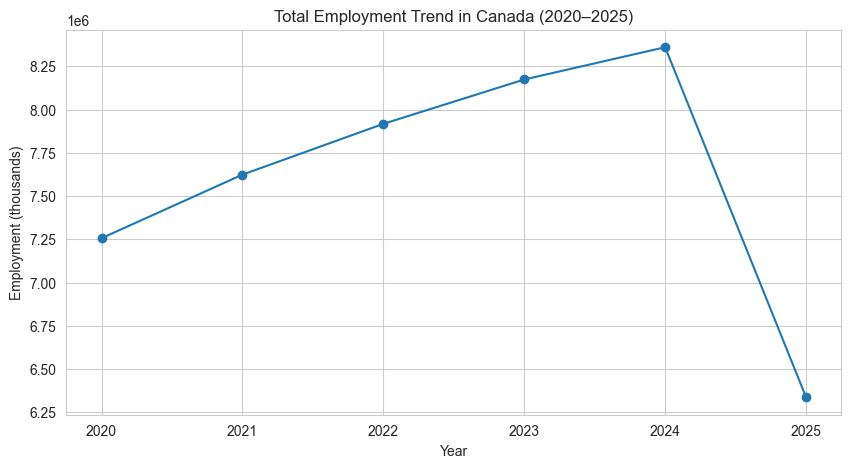

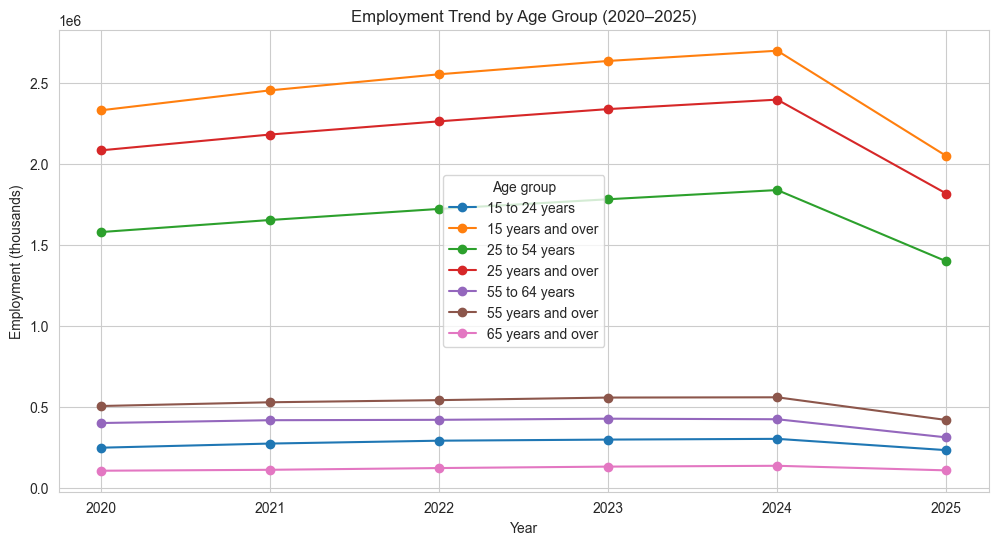

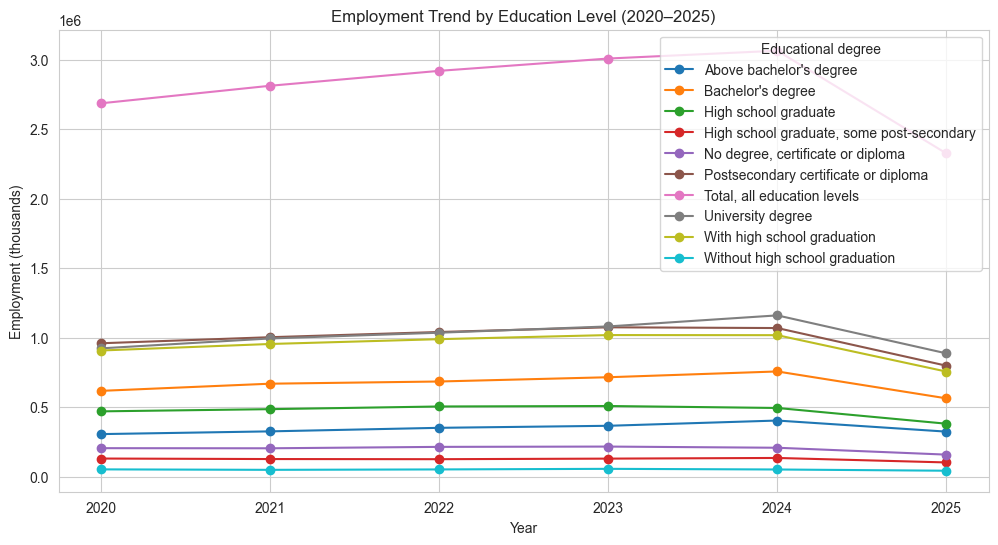

In [8]:
print("Age groups:", employment_df['Age group'].unique())
print("Education levels:", employment_df['Educational degree'].unique())
print("Genders:", employment_df['Gender'].unique())

employment_trend = (
    employment_df
    .groupby(employment_df['REF_DATE'].dt.year)['VALUE']
    .sum()
)
employment_trend

# Plotting the employment trends
plt.figure(figsize=(10, 5))
plt.plot(employment_trend.index, employment_trend.values, marker='o')
plt.title("Total Employment Trend in Canada (2020–2025)")
plt.xlabel("Year")
plt.ylabel("Employment (thousands)")
plt.grid(True)
plt.show()


# Employment trend by age group
age_trend = (
    employment_df
    .groupby([employment_df['REF_DATE'].dt.year, 'Age group'])['VALUE']
    .sum()
    .unstack()
)
age_trend.plot(figsize=(12, 6), marker='o')
plt.title("Employment Trend by Age Group (2020–2025)")
plt.xlabel("Year")
plt.ylabel("Employment (thousands)")
plt.grid(True)
plt.show()

#Employment trend by education level
education_trend = (
    employment_df
    .groupby([employment_df['REF_DATE'].dt.year, 'Educational degree'])['VALUE']
    .sum()
    .unstack()
)
education_trend.plot(figsize=(12, 6), marker='o')
plt.title("Employment Trend by Education Level (2020–2025)")
plt.xlabel("Year")
plt.ylabel("Employment (thousands)")
plt.grid(True)
plt.show()

## 📊 Employment Trends in Canada (2020–2025): Key Observations

Overall Employment Trend:

Employment grew steadily from 2020 to 2024, reflecting post-COVID recovery and strong economic expansion.

Employment peaked in 2024.

A sharp decline occurs in 2025, indicating:

Slower hiring or hiring freezes

Economic cooling

Possible AI-driven restructuring and automation reducing labour demand

Implication

The 2025 drop suggests a structural shift rather than a temporary fluctuation — consistent with accelerated adoption of automation and AI.



The labour market from 2020–2024 shows strong growth, but 2025 marks a significant downturn that disproportionately affects:

- lower-education workers
- younger and mid-career age groups
- occupations with routine or automatable tasks

These patterns strongly align with the hypothesis that AI adoption and automation are beginning to reshape the Canadian workforce, increasing demand for skilled labour while reducing opportunities for routine and lower-skilled jobs.

## We'll now observe the unemployement data

In [9]:
unemployment_df = EE_Wage_Trend[EE_Wage_Trend["Labour force characteristics"] == "Unemployment"].copy()
unemployment_df.head()

,REF_DATE,GEO,DGUID,Labour force characteristics,Educational degree,Gender,Age group,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
8317050,2020-01-01,Canada,2021A000011124,Unemployment,"Total, all education levels",Total - Gender,15 years and over,Persons in thousands,428,thousands,3,v54911770,1.6.1.1.1,1192.1,NaN,NaN,NaN,1
8317051,2020-01-01,Canada,2021A000011124,Unemployment,"Total, all education levels",Total - Gender,15 to 24 years,Persons in thousands,428,thousands,3,v54911771,1.6.1.1.2,278.9,NaN,NaN,NaN,1
8317052,2020-01-01,Canada,2021A000011124,Unemployment,"Total, all education levels",Total - Gender,25 years and over,Persons in thousands,428,thousands,3,v54911772,1.6.1.1.3,913.2,NaN,NaN,NaN,1
8317053,2020-01-01,Canada,2021A000011124,Unemployment,"Total, all education levels",Total - Gender,25 to 54 years,Persons in thousands,428,thousands,3,v54911773,1.6.1.1.4,681.2,NaN,NaN,NaN,1
8317054,2020-01-01,Canada,2021A000011124,Unemployment,"Total, all education levels",Total - Gender,55 years and over,Persons in thousands,428,thousands,3,v54911774,1.6.1.1.5,232.0,NaN,NaN,NaN,1


REF_DATE
2020    687348.2
2021    564854.6
2022    396611.9
2023    414466.2
2024    499123.0
2025    422124.3
Name: VALUE, dtype: float64


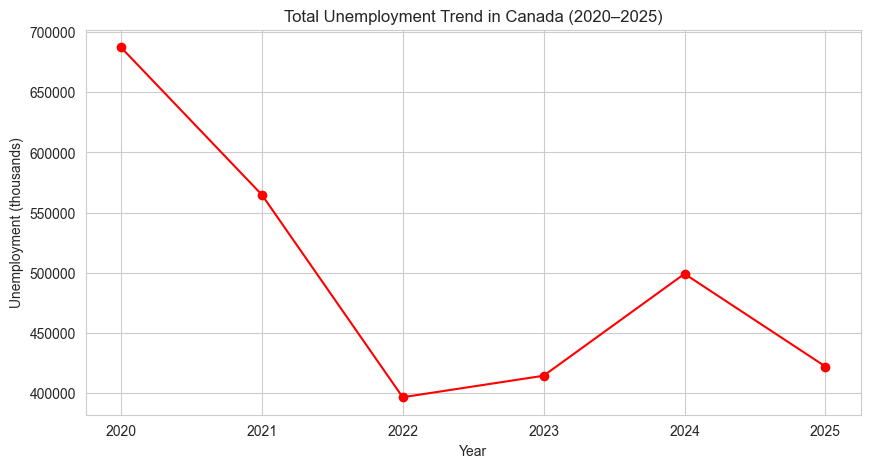

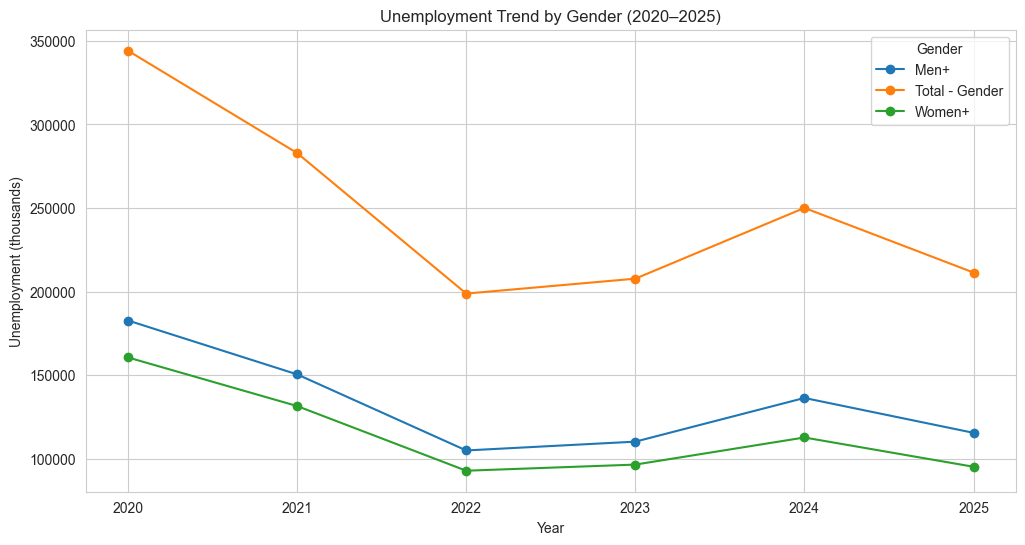

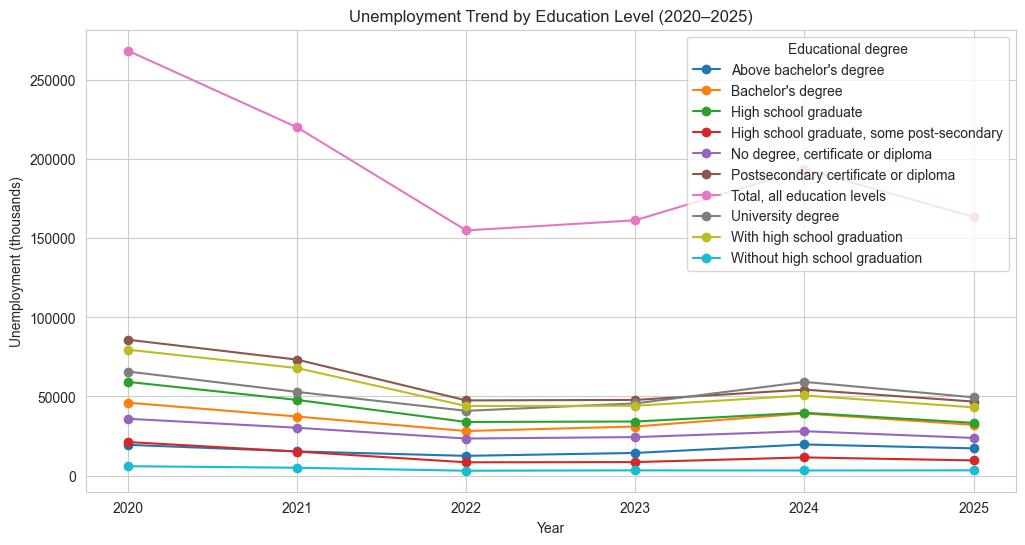

In [10]:

unemployment_trend = (
    unemployment_df
    .groupby(unemployment_df['REF_DATE'].dt.year)['VALUE']
    .sum()
)

# print data size of unemployment trend
print(unemployment_trend)


# Plotting the unemployment trends
plt.figure(figsize=(10, 5))
plt.plot(unemployment_trend.index, unemployment_trend.values, marker='o', color='red')
plt.title("Total Unemployment Trend in Canada (2020–2025)")
plt.xlabel("Year")
plt.ylabel("Unemployment (thousands)")
plt.grid(True)
plt.show()

# Unemployment trend by gender 
gender_trend = (
    unemployment_df
    .groupby([unemployment_df['REF_DATE'].dt.year, 'Gender'])['VALUE']
    .sum()
    .unstack()
)
gender_trend.plot(figsize=(12, 6), marker='o')
plt.title("Unemployment Trend by Gender (2020–2025)")
plt.xlabel("Year")
plt.ylabel("Unemployment (thousands)")
plt.grid(True)
plt.show()

# Employment trend by education level
education_unemp_trend = (
    unemployment_df
    .groupby([unemployment_df['REF_DATE'].dt.year, 'Educational degree'])['VALUE']
    .sum()
    .unstack()
)
education_unemp_trend.plot(figsize=(12, 6), marker='o')
plt.title("Unemployment Trend by Education Level (2020–2025)")
plt.xlabel("Year")
plt.ylabel("Unemployment (thousands)")
plt.grid(True)
plt.show()

## 📉 Unemployment Trends in Canada (2020–2025): Key Observations
Overall Unemployment Trend

Unemployment dropped sharply from 2020 to 2022, reflecting economic recovery after the COVID shock.

A slight uptick occurs in 2023–2024, suggesting early signs of labour market softening.
2025 shows a decline again, but still higher than the lowest point in 2022.

What This Implies
- The recovery phase (2020→2022) shows strong rehiring and economic stabilization.
- The rise in 2023–2024 signals slower job creation, economic cooling, and potential structural changes.
- The mix of decline + volatility suggests the labour market is tightening, not simply fluctuating.

The unemployment data shows that:
- Recovery (2020–2022) was strong.
- Pressure increases (2023–2024) indicate cooling labour demand.
- Education level becomes a major buffer, with low-education groups facing the biggest risk.
- These patterns align with AI and automation replacing routine work, while boosting demand for skilled and educated workers.

# We'll now examine employement and unemployment rates

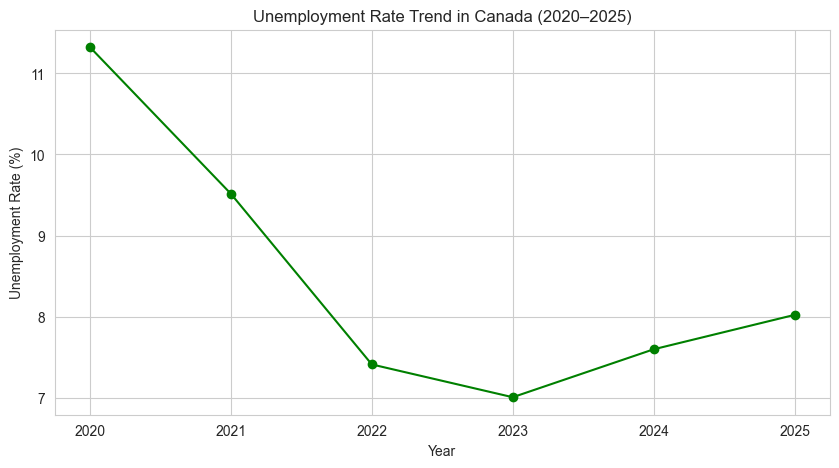

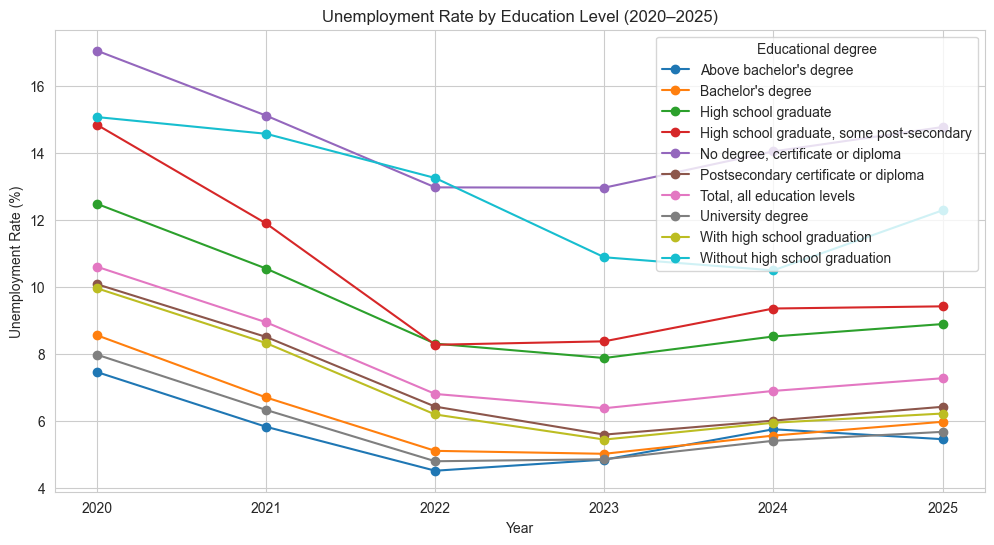

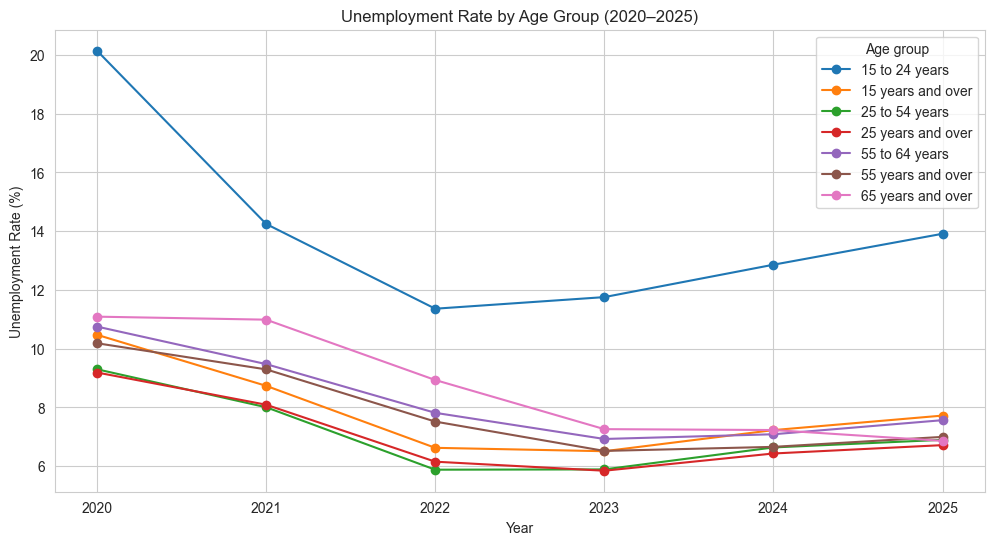

In [11]:
unemployment_rate = EE_Wage_Trend[EE_Wage_Trend["Labour force characteristics"] == "Unemployment rate"].copy()
unemployment_rate.head()
unemployment_rate_trend = (
    unemployment_rate
    .groupby(unemployment_rate['REF_DATE'].dt.year)['VALUE']
    .mean()
)
unemployment_rate_trend.plot(figsize=(10, 5), marker='o', color='green')
plt.title("Unemployment Rate Trend in Canada (2020–2025)")
plt.xlabel("Year")
plt.ylabel("Unemployment Rate (%)")
plt.grid(True)
plt.show()

#unemployment rate by education level
education_unemp_rate_trend = (
    unemployment_rate
    .groupby([unemployment_rate['REF_DATE'].dt.year, 'Educational degree'])['VALUE']
    .mean()
    .unstack()
)
education_unemp_rate_trend.plot(figsize=(12, 6), marker='o')
plt.title("Unemployment Rate by Education Level (2020–2025)")
plt.xlabel("Year")
plt.ylabel("Unemployment Rate (%)")
plt.grid(True)
plt.show()

# unemployment rate by age group
age_unemp_rate_trend = (
    unemployment_rate
    .groupby([unemployment_rate['REF_DATE'].dt.year, 'Age group'])['VALUE']
    .mean()
    .unstack()
)
age_unemp_rate_trend.plot(figsize=(12, 6), marker='o')
plt.title("Unemployment Rate by Age Group (2020–2025)")
plt.xlabel("Year")
plt.ylabel("Unemployment Rate (%)")
plt.grid(True)
plt.show()

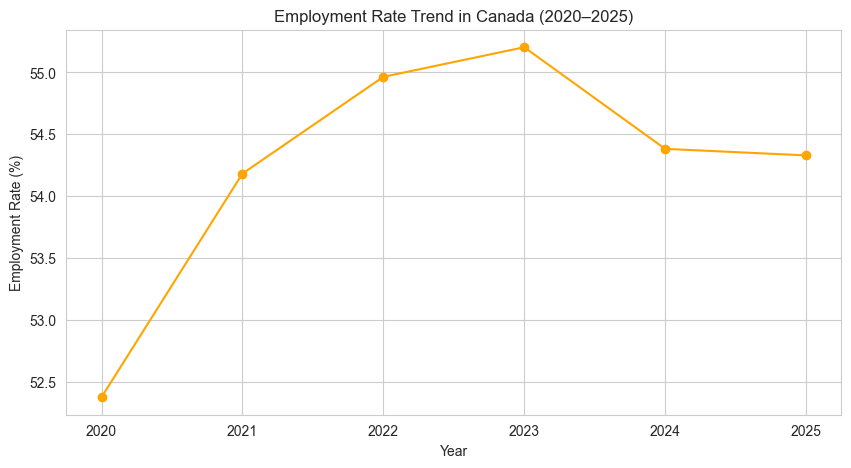

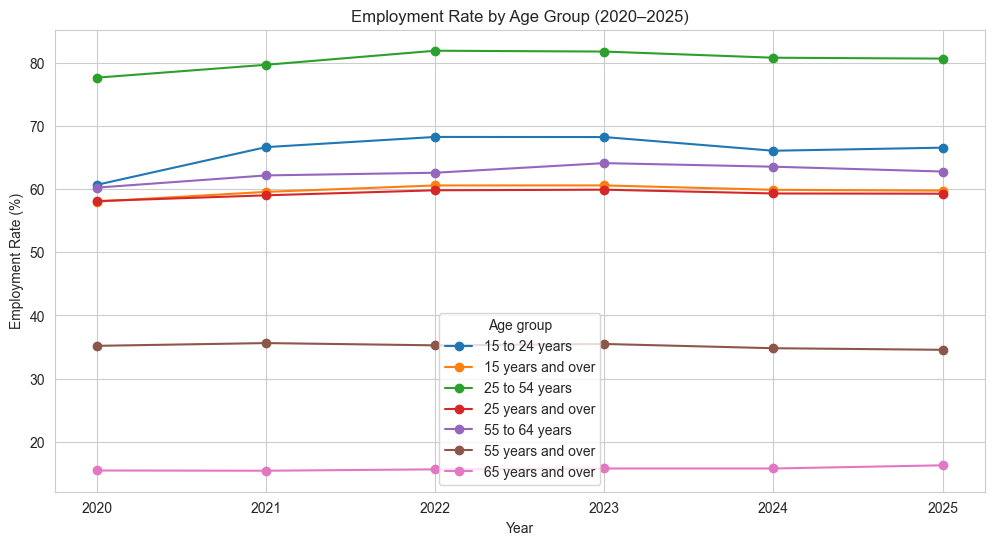

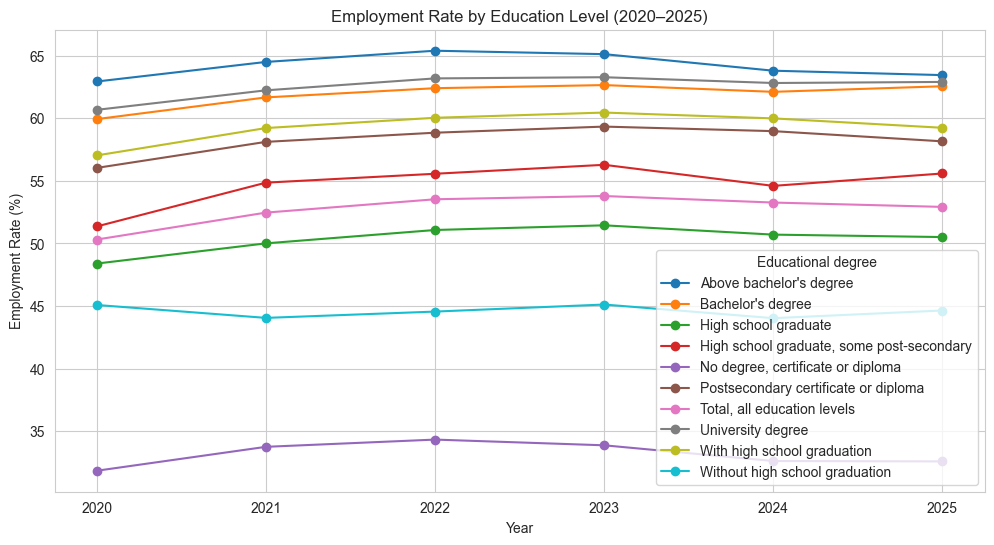

In [12]:
# Employment Rate Trend
employment_rate_df = EE_Wage_Trend[EE_Wage_Trend["Labour force characteristics"] == "Employment rate"].copy()
employment_rate_trend = (
    employment_rate_df
    .groupby(employment_rate_df['REF_DATE'].dt.year)['VALUE']
    .mean()
)
employment_rate_trend

# Plotting the employment rate trend
plt.figure(figsize=(10, 5))
plt.plot(employment_rate_trend.index, employment_rate_trend.values, marker='o', color='orange')
plt.title("Employment Rate Trend in Canada (2020–2025)")
plt.xlabel("Year")
plt.ylabel("Employment Rate (%)")
plt.grid(True)
plt.show()

# Employment rate by Age Group
age_rate_trend = (
    employment_rate_df
    .groupby([employment_rate_df['REF_DATE'].dt.year, 'Age group'])['VALUE']
    .mean()
    .unstack()
)
age_rate_trend.plot(figsize=(12, 6), marker='o')
plt.title("Employment Rate by Age Group (2020–2025)")
plt.xlabel("Year")
plt.ylabel("Employment Rate (%)")
plt.grid(True)
plt.show()

# Employment rate by Education Level
education_rate_trend = (
    employment_rate_df
    .groupby([employment_rate_df['REF_DATE'].dt.year, 'Educational degree'])['VALUE']
    .mean()
    .unstack()
)
education_rate_trend.plot(figsize=(12, 6), marker='o')
plt.title("Employment Rate by Education Level (2020–2025)")
plt.xlabel("Year")
plt.ylabel("Employment Rate (%)")
plt.grid(True)
plt.show()

### 1. Higher-educated workers remain protected

Workers with university or above-bachelor's degrees show high and stable employment rates across all years.
Why?
- AI complements highly skilled labour
- Higher demand for tech-literate professionals
- Growth in AI-enabled sectors (tech, finance, engineering, analytics)
- AI increases the value of high-skill labour rather than replacing it. (Potentially?)

### 2. Lower-education groups show signs of early displacement

Workers with no diploma, high school only, or partial post-secondary experience flat or declining employment rates after 2023.
Why?
- These groups work in roles that AI automates first:
- Routine administrative tasks
- Customer service
- Basic service roles
- Repetitive clerical or processing work
- AI pressure appears strongest on routine, lower-skill jobs.

### 3. Younger workers face more volatility
Ages 15–24 show faster rises and sharper drops, especially by 2024–2025.
Why?
- They are heavily employed in:
- Retail
- Food service
- Entry-level office roles
- Customer support
- AI reduces entry-level opportunities, making it harder for youth to enter stable employment.

### 4. Prime-age workers (25–54) remain stable
- This group shows minimal disruption, suggesting:
- Experience and adaptability protect them
- Their roles involve judgment, leadership, and complex decision-making
- AI augments but does not replace them (yet)
- AI currently complements mid-career workers more than replacing them.

### 5. 2025 slowdown aligns with an AI-driven shift
- Across all charts, 2025 shows:
- A drop in employment levels
- A drop in employment rates
- Larger declines for lower-education groups
- Much smaller declines for high-education groups

This pattern matches early-stage AI adoption
- Less demand for repetitive labour
- Slower hiring for entry-level and routine tasks
- Increased productivity reducing headcount needs
- Higher demand for specialized, highly skilled workers

Overall Summary

Employment trends suggest that AI is beginning to polarize the labour market—boosting opportunities for high-skilled workers while reducing stability and demand for lower-education and routine-task workers. The 2025 downturn likely reflects the early phase of AI-driven restructuring rather than typical economic fluctuations.

# We'll now take a look at labour force participation

What is the labour force?
The labour force includes **everyone who is working or actively looking for work**.  
It does *not* include retirees, full-time students who aren’t job searching, or discouraged workers who stopped looking.

['Population' 'Labour force' 'Employment' 'Full-time employment'
 'Part-time employment' 'Unemployment' 'Not in labour force'
 'Unemployment rate' 'Participation rate' 'Employment rate']


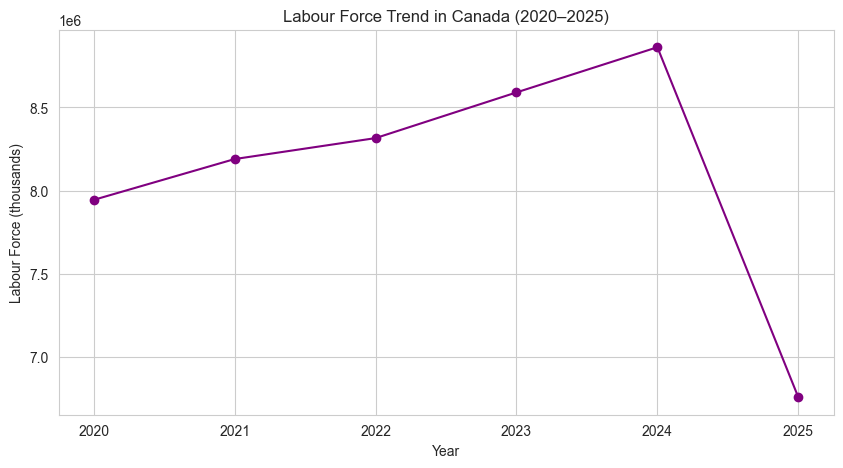

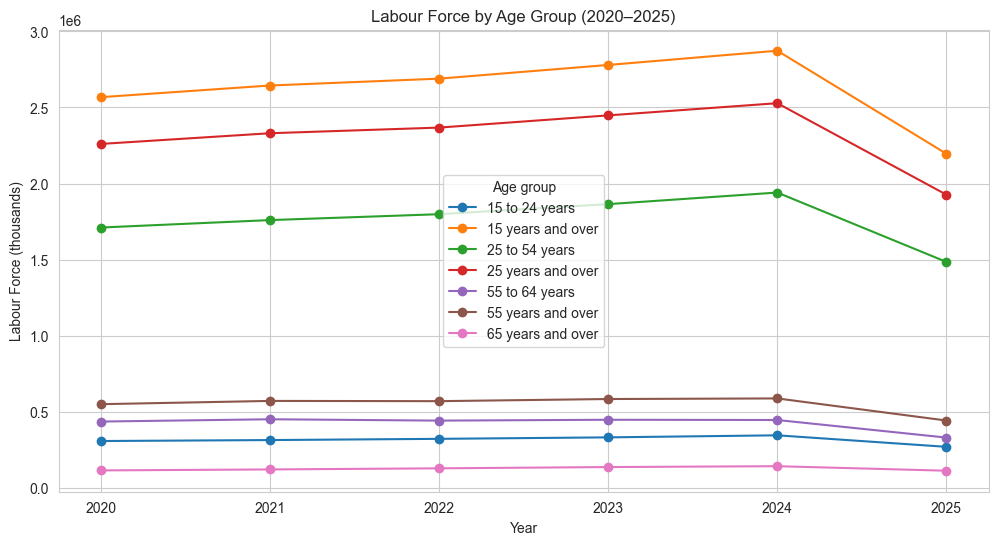

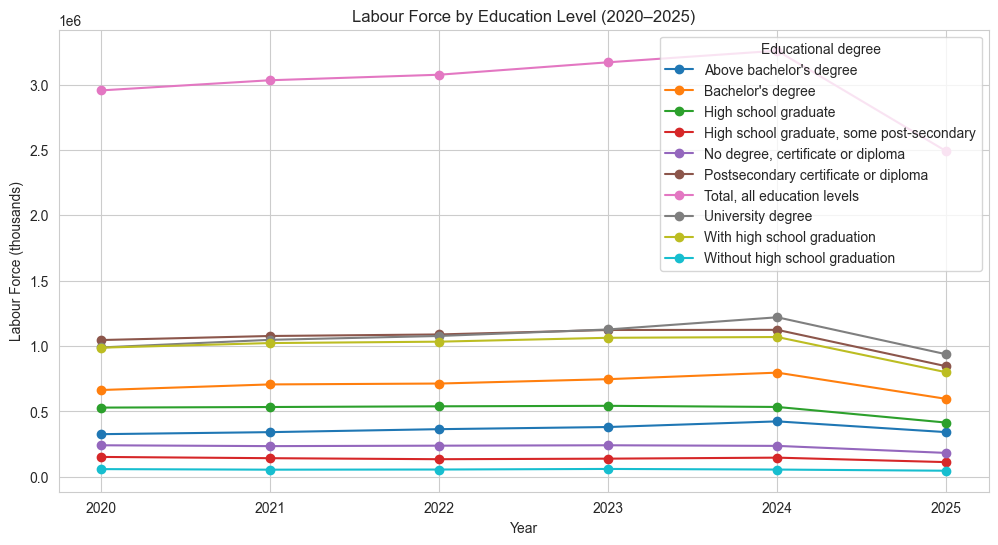

In [13]:
#print out all labour force characteristics
print(EE_Wage_Trend['Labour force characteristics'].unique())

Labour_force_Participation = EE_Wage_Trend[EE_Wage_Trend["Labour force characteristics"] == "Labour force"].copy()
Labour_force_Participation.head()

labour_force_trend = (
    Labour_force_Participation
    .groupby(Labour_force_Participation['REF_DATE'].dt.year)['VALUE']
    .sum()
)
labour_force_trend  
# Plotting the labour force trend
plt.figure(figsize=(10, 5))
plt.plot(labour_force_trend.index, labour_force_trend.values, marker='o', color='purple')
plt.title("Labour Force Trend in Canada (2020–2025)")
plt.xlabel("Year")
plt.ylabel("Labour Force (thousands)")
plt.grid(True)
plt.show()

# labour force by age group
age_labour_trend = (
    Labour_force_Participation
    .groupby([Labour_force_Participation['REF_DATE'].dt.year, 'Age group'])['VALUE']
    .sum()
    .unstack()
)
age_labour_trend.plot(figsize=(12, 6), marker='o')
plt.title("Labour Force by Age Group (2020–2025)")
plt.xlabel("Year")
plt.ylabel("Labour Force (thousands)")
plt.grid(True)
plt.show()  

# labour force by education level
education_labour_trend = (
    Labour_force_Participation
    .groupby([Labour_force_Participation['REF_DATE'].dt.year, 'Educational degree'])['VALUE']
    .sum()
    .unstack()
)
education_labour_trend.plot(figsize=(12, 6), marker='o')
plt.title("Labour Force by Education Level (2020–2025)")
plt.xlabel("Year")
plt.ylabel("Labour Force (thousands)")
plt.grid(True)
plt.show()




## 📈 2020–2024: Steady Growth
From 2020 to 2024, Canada’s labour force **grew consistently**, reflecting:
- Strong population and immigration growth  
- Post-COVID economic recovery  
- High job availability  
- Increased confidence in the job market  

More people felt motivated to seek work.


## 2025: Sharp and Unusual Decline
The labour force drops sharply in 2025 — the largest decline in the entire period.

This suggests a **major structural shift**, likely caused by:

### **1. Discouraged workers leaving the job market**
When job opportunities shrink, especially for low-skill or routine work, people stop searching and exit the labour force.

### **2. AI and automation pressure**
If AI reduces demand for administrative, clerical, or basic service roles, displaced workers may:
- Give up job searching  
- Go back to school  
- Shift to informal work  
- Retire early  

### **3. Economic cooling or hiring freezes**
Companies reducing hiring can decrease participation.

### **4. Youth delaying entry**
Young workers may remain in school longer if job prospects weaken.


## Summary
The large 2025 drop suggests **fewer Canadians are working or searching for work**, which aligns with:
- rising unemployment for some groups  
- falling employment for low-education and youth groups  
- evidence of automation and AI beginning to reshape the labour market  


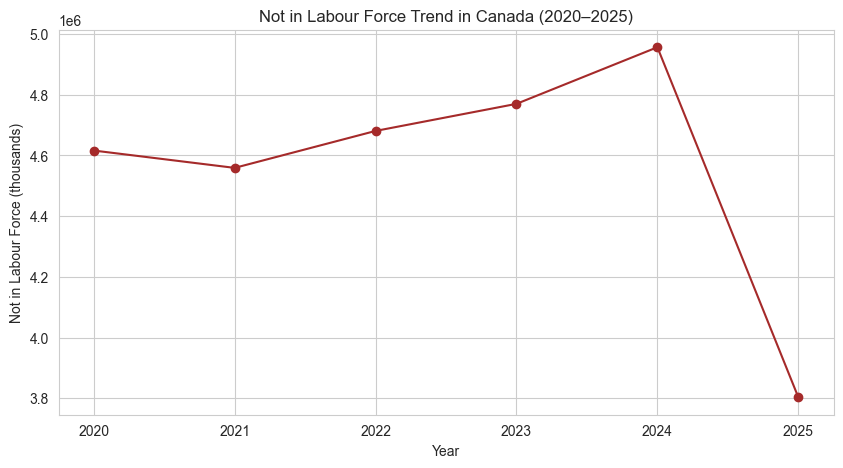

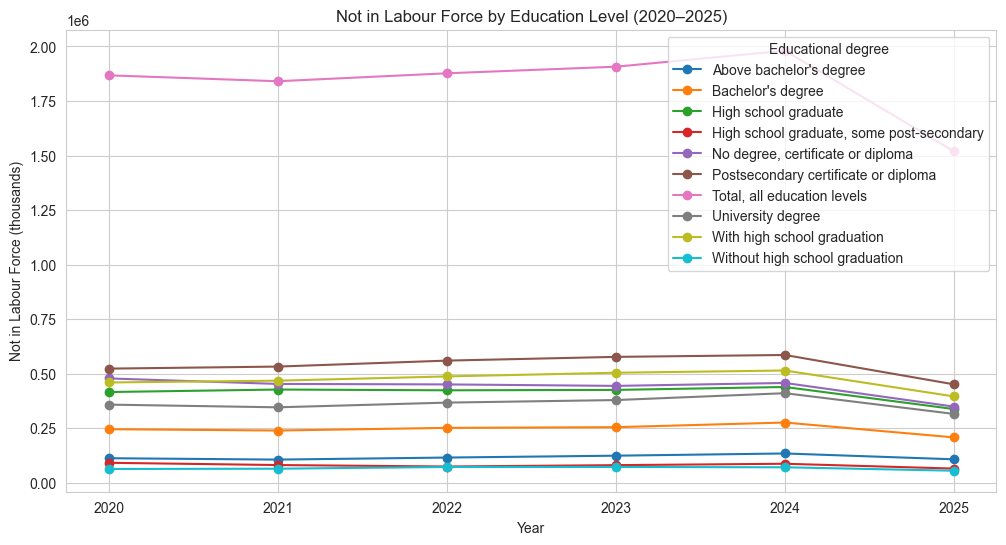

In [14]:
EE_Wage_Trend["Labour force characteristics"].unique()

# get the not in labour force data
not_in_labour_force = EE_Wage_Trend[EE_Wage_Trend["Labour force characteristics"] == "Not in labour force"].copy()
not_in_labour_force.head()  

not_in_labour_trend = (
    not_in_labour_force
    .groupby(not_in_labour_force['REF_DATE'].dt.year)['VALUE']
    .sum()
)
not_in_labour_trend  
# Plotting the not in labour force trend
plt.figure(figsize=(10, 5))
plt.plot(not_in_labour_trend.index, not_in_labour_trend.values, marker='o', color='brown')
plt.title("Not in Labour Force Trend in Canada (2020–2025)")
plt.xlabel("Year")
plt.ylabel("Not in Labour Force (thousands)")
plt.grid(True)
plt.show()

# not in labour force by education level
education_not_in_labour_trend = (
    not_in_labour_force
    .groupby([not_in_labour_force['REF_DATE'].dt.year, 'Educational degree'])['VALUE']
    .sum()
    .unstack()
)
education_not_in_labour_trend.plot(figsize=(12, 6), marker='o')
plt.title("Not in Labour Force by Education Level (2020–2025)")
plt.xlabel("Year")
plt.ylabel("Not in Labour Force (thousands)")
plt.grid(True)
plt.show()

# Shifting focus to the use of AI by Businesses, by Industry

In [50]:
AI_use_df = pd.read_csv("data/33100878.csv")
print(AI_use_df.head())
print(AI_use_df.columns)
print(AI_use_df.shape)

   REF_DATE     GEO           DGUID                           Business characteristics Use of artificial intelligence (AI) by businesses or organizations in producing goods or delivering services over the next 12 months      UOM  UOM_ID SCALAR_FACTOR  SCALAR_ID       VECTOR COORDINATE  VALUE STATUS  SYMBOL  TERMINATED  DECIMALS
0      2024  Canada  2021A000011124  North American Industry Classification System ...  Yes, business plans to use AI for producing go...                                                                                    Percent     239         units          0  v1594336625      1.1.1   10.6      A     NaN         NaN         1
1      2024  Canada  2021A000011124  North American Industry Classification System ...  Type of AI application planned to use, machine...                                                                                    Percent     239         units          0  v1594336636      1.1.2   18.8      B     NaN         NaN         1
2      202

In [51]:
# get the businesses characteristics related to AI use
print(AI_use_df["Business characteristics"].unique())

print("-----------")
print(AI_use_df["Use of artificial intelligence (AI) by businesses or organizations in producing goods or delivering services over the next 12 months"].unique())

['North American Industry Classification System (NAICS), all industries'
 'Agriculture, forestry, fishing and hunting [11]'
 'Mining, quarrying, and oil and gas extraction [21]' 'Construction [23]'
 'Manufacturing [31-33]' 'Wholesale trade [41]' 'Retail trade [44-45]'
 'Transportation and warehousing [48-49]'
 'Information and cultural industries [51]' 'Finance and insurance [52]'
 'Real estate and rental and leasing [53]'
 'Professional, scientific and technical services [54]'
 'Administrative and support, waste management and remediation services [56]'
 'Health care and social assistance [62]'
 'Arts, entertainment and recreation [71]'
 'Accommodation and food services [72]'
 'Other services (except public administration) [81]'
 'Business or organization size of employment, all employment sizes'
 '1 to 4 employees' '5 to 19 employees' '20 to 99 employees'
 '100 or more employees'
 'Business or organization type, all businesses or organizations'
 'Government agencies' 'Private sector 

In [52]:
#shorten the column name for easier access
from ast import For

AI_use_df = AI_use_df.rename(columns={"Use of artificial intelligence (AI) by businesses or organizations in producing goods or delivering services over the next 12 months": "AI Use Next 12 Months"})

def clean_ai_label(text):

    # 1. Handle "YES"
    if text.startswith("Yes, business plans to use AI"):
        return "Producing goods & services"
    
    # 2. Handle "NO"
    if text.startswith("No, business or organization does not plan"):
        return "No use"
    
    # 3. Handle "UNKNOWN"
    if "unknown" in text.lower():
        return "Unknown"

    # 4. Handle all "Type of AI application planned to use, X"
    if "Type of AI application planned to use" in text:
        # I WANT EVERYTHING AFTER THE , NOT JUST THE FIRST WORD
        parts = text.split(",")
        if len(parts) > 1:
            return parts[1].strip()

    # 5. Fallback
    return text.split(" ")[0]



AI_use_df["AI Use Next 12 Months"] = AI_use_df["AI Use Next 12 Months"].apply(clean_ai_label)

print(AI_use_df["AI Use Next 12 Months"].unique())



['Producing goods & services' 'machine learning'
 'natural language processing' 'virtual agents or chatbots'
 'speech or voice recognition using AI' 'recommendation systems using AI'
 'large language models' 'text analytics using AI'
 'data analytics using AI' 'neural network' 'augmented reality'
 'decision making systems based on AI' 'deep learning'
 'image or pattern recognition' 'machine or computer vision'
 'robotics process automation' 'biometrics'
 'marketing automation using AI' 'other type' 'No use' 'Unknown']


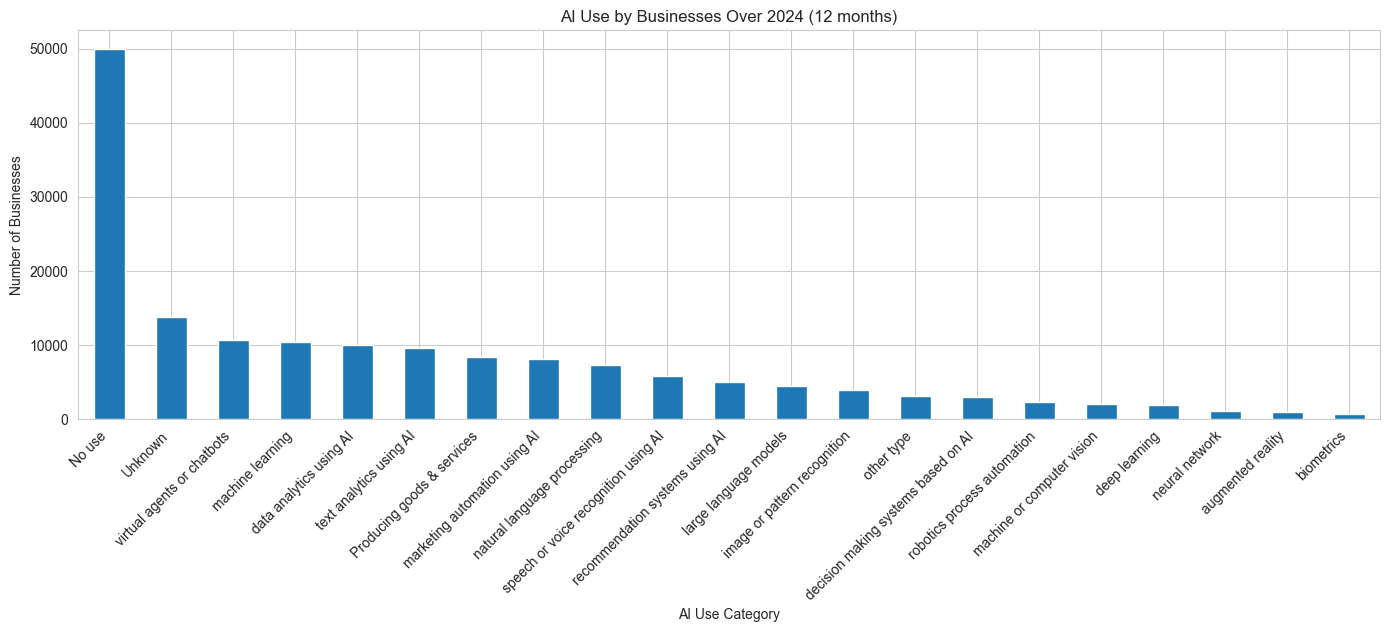

In [53]:

ai_use_trend = (
    AI_use_df
    .groupby('AI Use Next 12 Months')['VALUE']
    .sum()
    .sort_values(ascending=False)
)

ax = ai_use_trend.plot(kind='bar', figsize=(14, 7))
ax.set_title("AI Use by Businesses Over 2024 (12 months)")
ax.set_xlabel("AI Use Category")
ax.set_ylabel("Number of Businesses")
ax.grid(True)
plt.tight_layout()

# rotate x labels for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

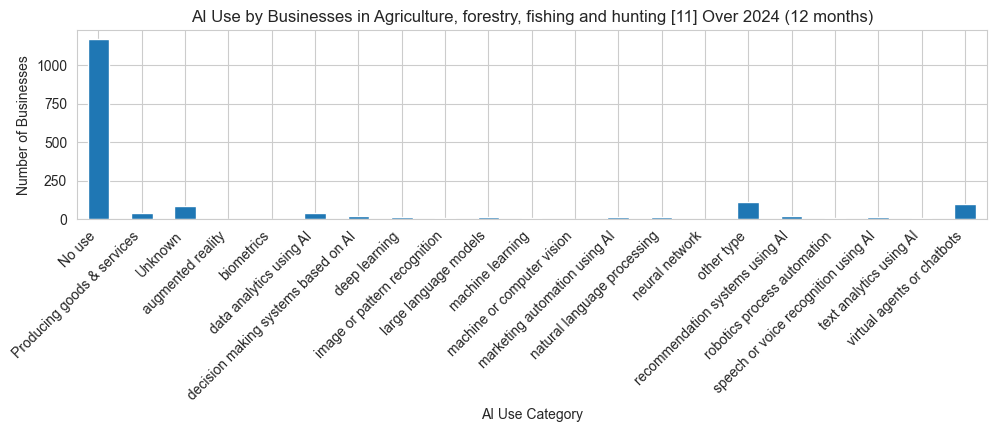

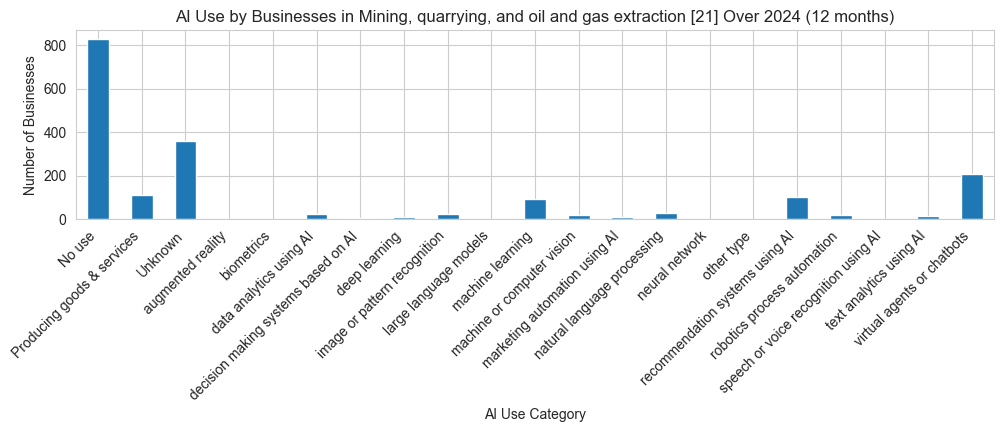

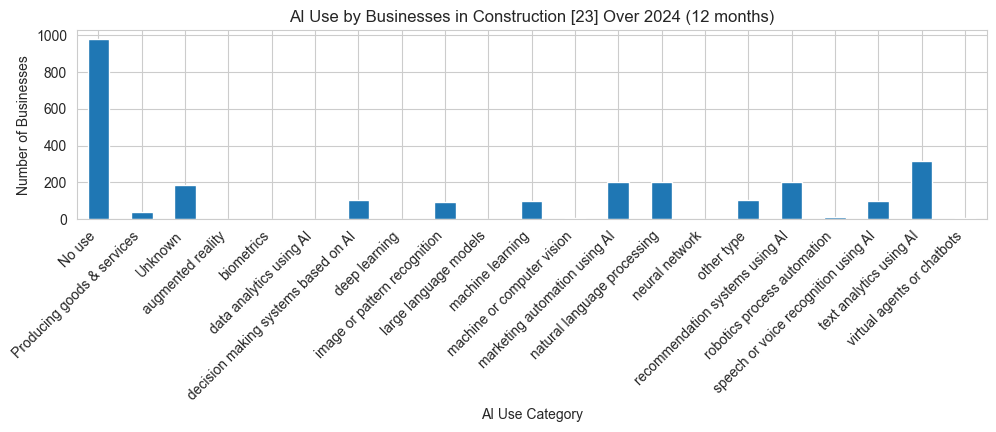

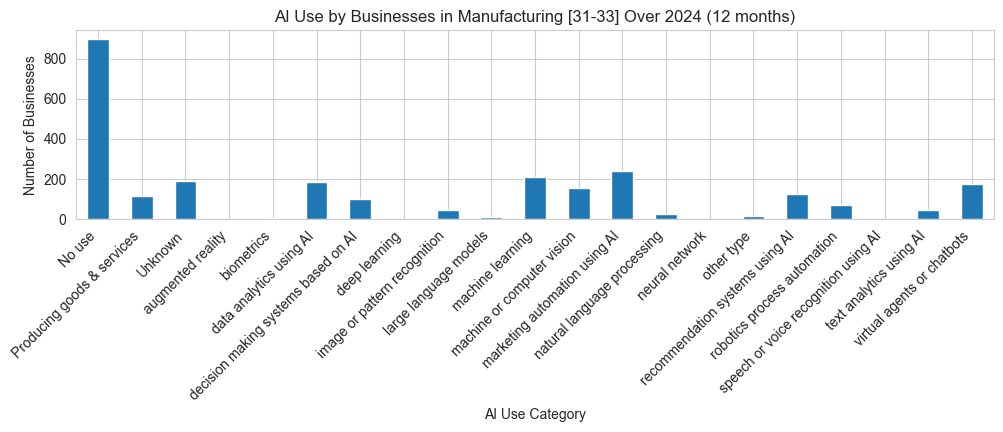

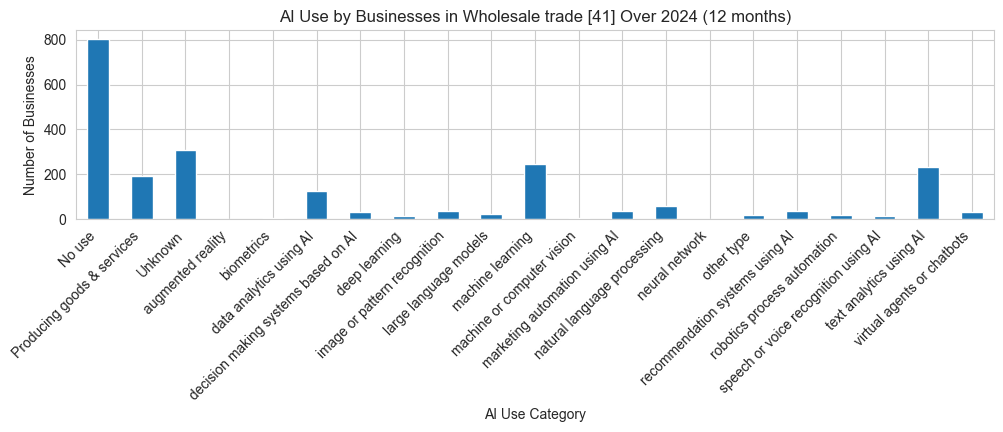

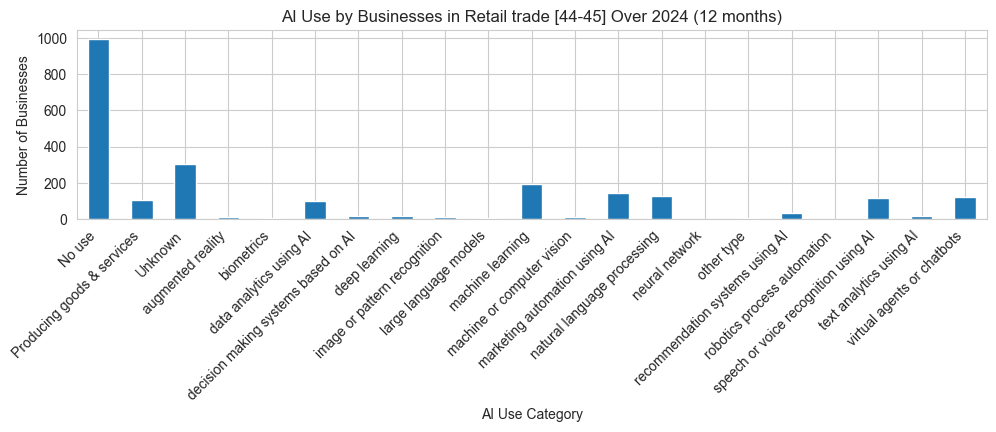

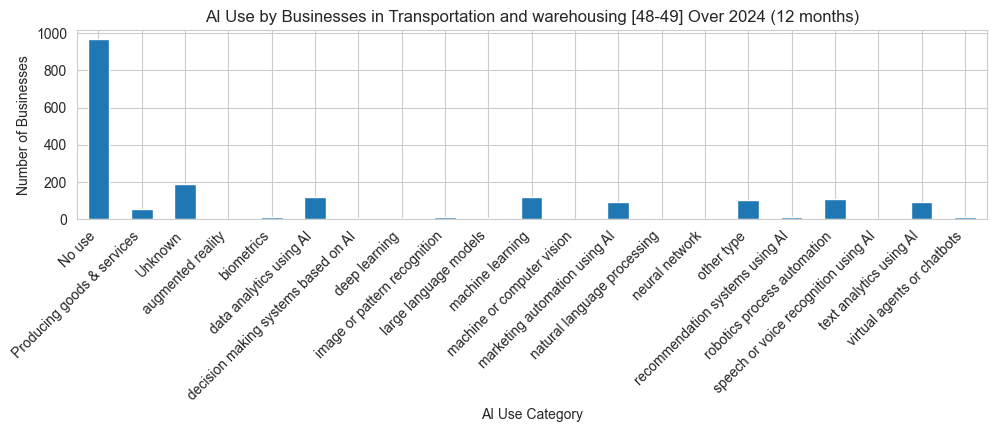

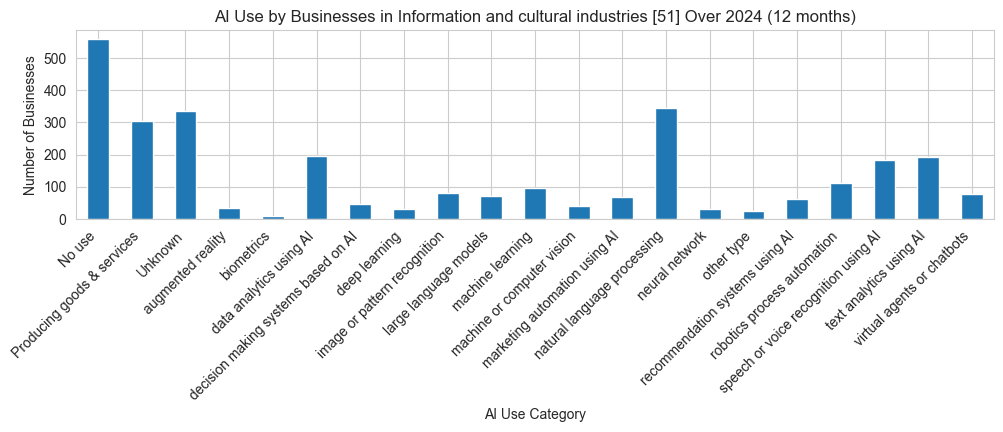

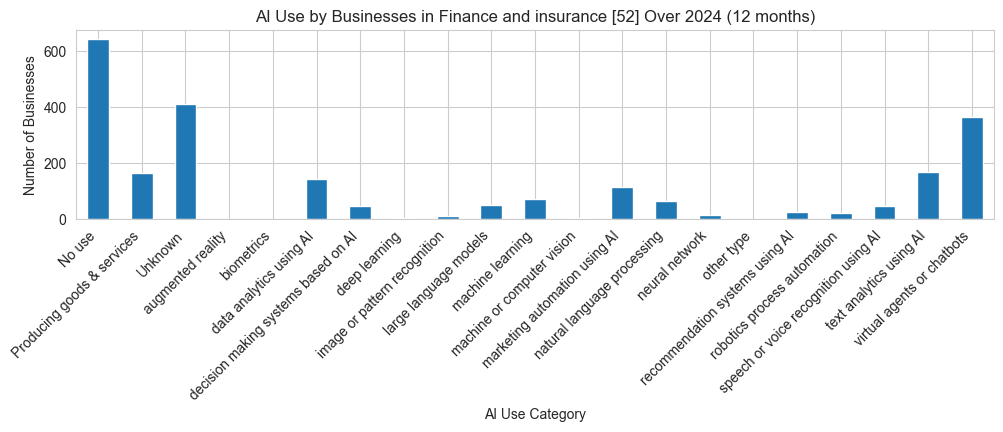

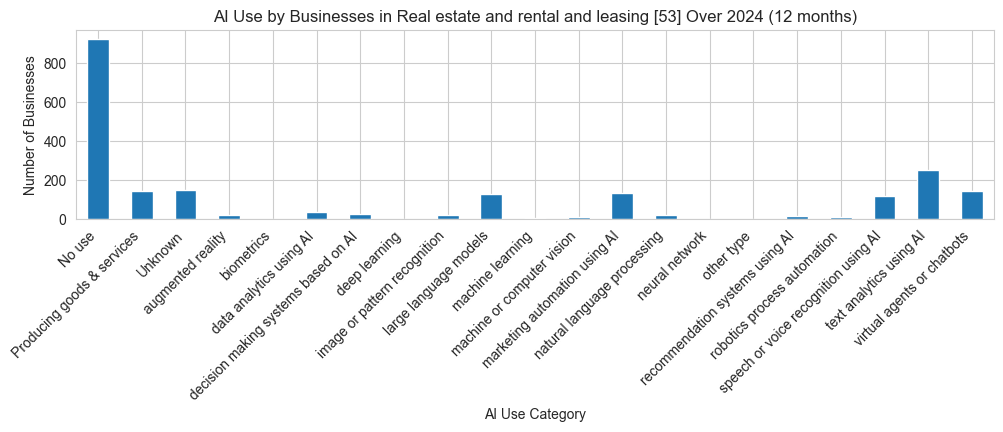

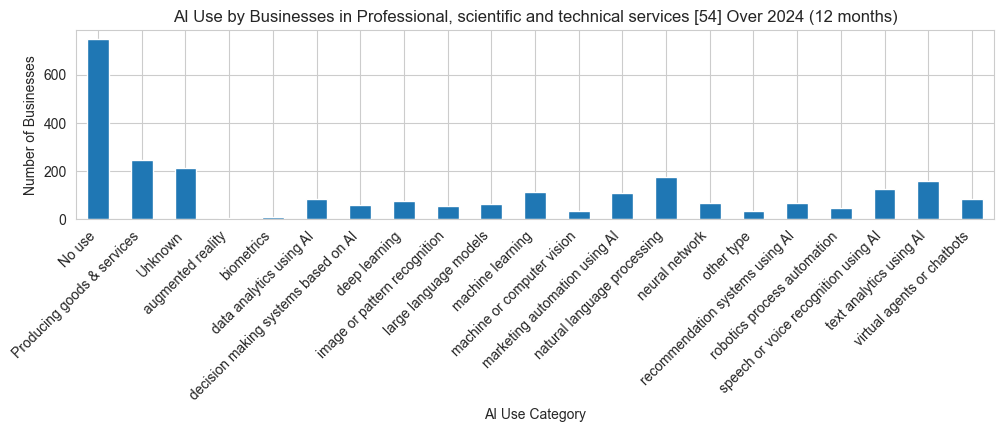

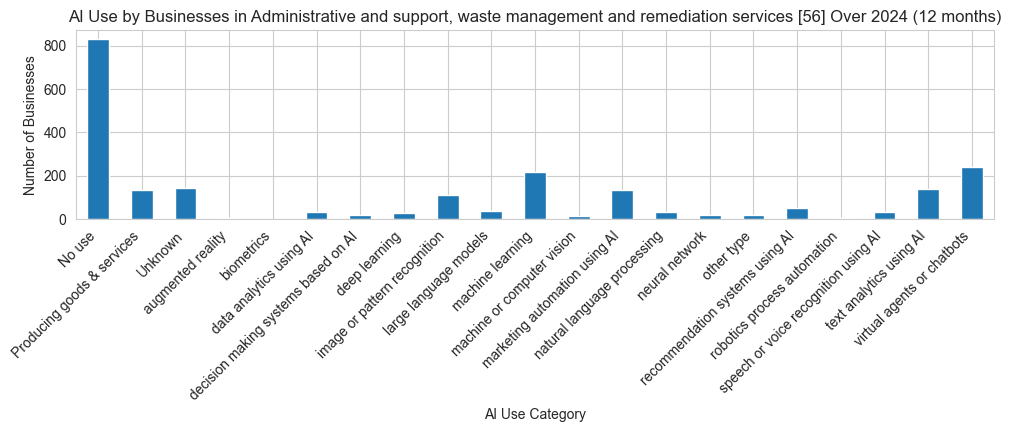

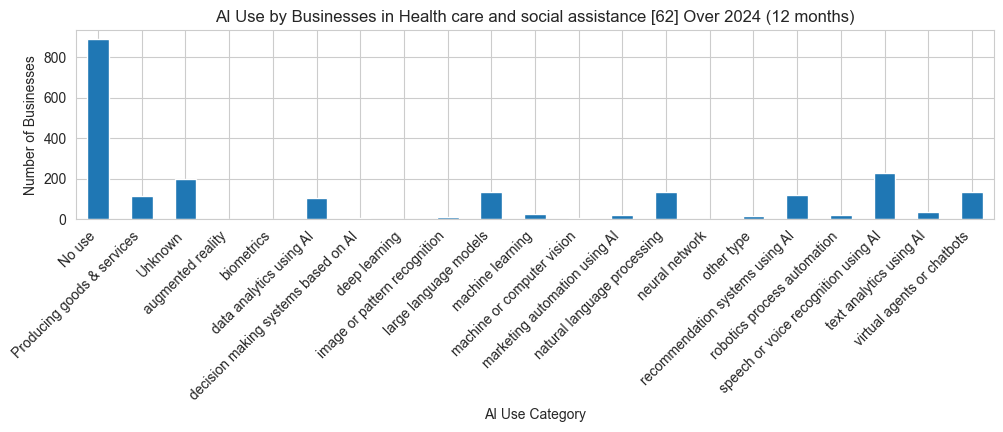

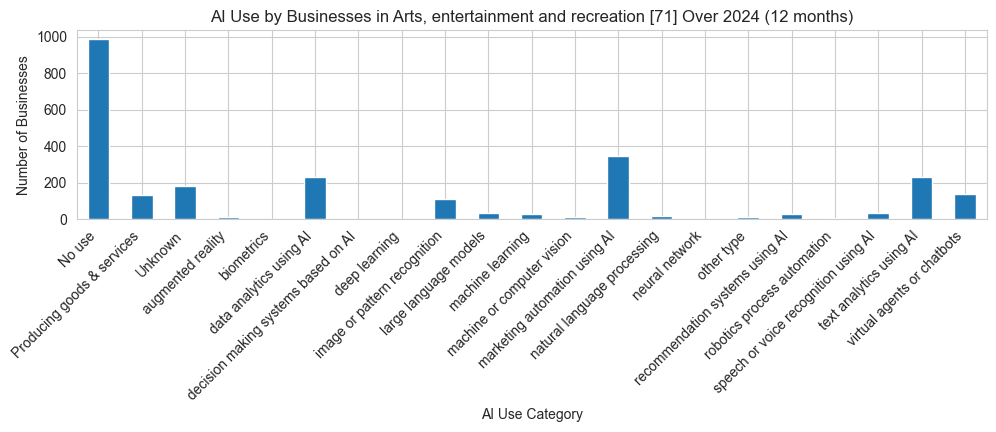

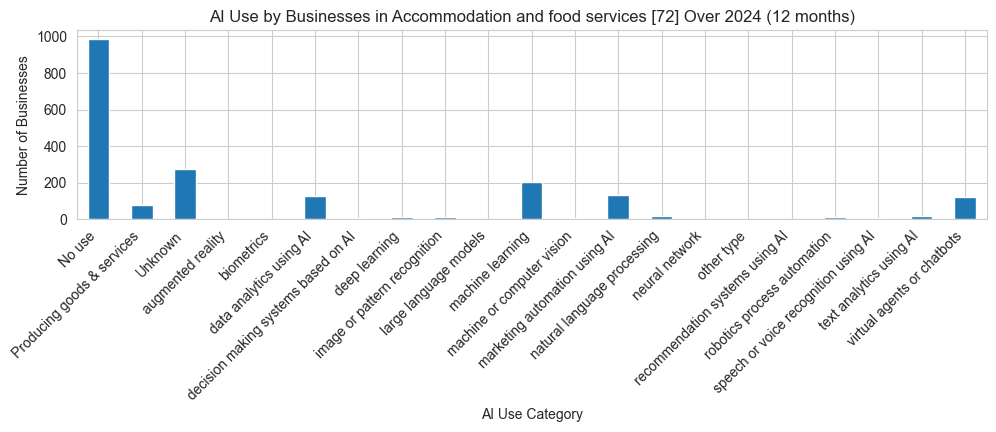

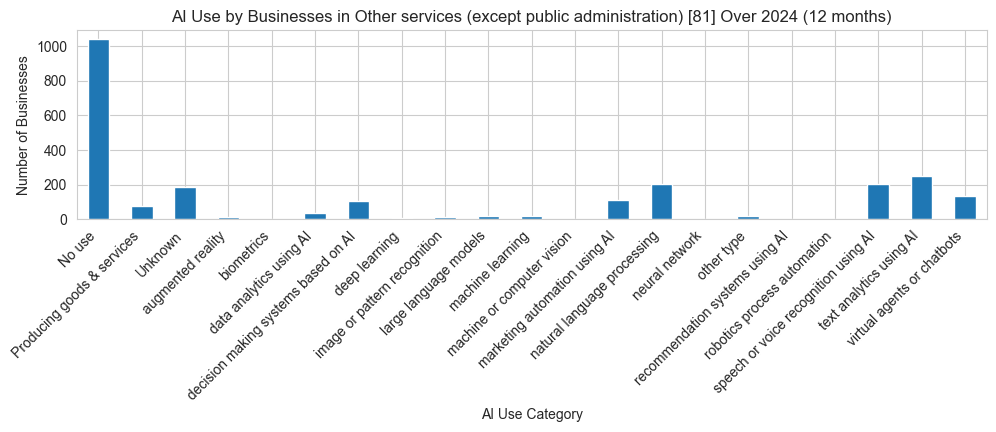

In [54]:
business_sectors = [
    'Agriculture, forestry, fishing and hunting [11]',
    'Mining, quarrying, and oil and gas extraction [21]',
    'Construction [23]',
    'Manufacturing [31-33]',
    'Wholesale trade [41]',
    'Retail trade [44-45]',
    'Transportation and warehousing [48-49]',
    'Information and cultural industries [51]',
    'Finance and insurance [52]',
    'Real estate and rental and leasing [53]',
    'Professional, scientific and technical services [54]',
    'Administrative and support, waste management and remediation services [56]',
    'Health care and social assistance [62]',
    'Arts, entertainment and recreation [71]',
    'Accommodation and food services [72]',
    'Other services (except public administration) [81]']

ai_sector_trend = (
    AI_use_df[AI_use_df['Business characteristics'].isin(business_sectors)]
    .groupby(['Business characteristics', 'AI Use Next 12 Months'])['VALUE']
    .sum()
    .unstack()
    .fillna(0)
)   

# plot each sector individually
for sector in business_sectors:
    if sector in ai_sector_trend.index:
        sector_data = ai_sector_trend.loc[sector]
        ax = sector_data.plot(kind='bar', figsize=(10, 5))
        ax.set_title(f"AI Use by Businesses in {sector} Over 2024 (12 months)")
        ax.set_xlabel("AI Use Category")
        ax.set_ylabel("Number of Businesses")
        ax.grid(True)
        plt.tight_layout()
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        plt.show()